In [438]:
import xarray as xr
import pandas as pd
import glob 
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np
import h5py
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import netCDF4
from netCDF4 import Dataset
import time 
import pyart 
import matplotlib.colors as colors
import time 
import matplotlib.dates as md
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

np.seterr(divide = 'ignore'); 
import warnings
warnings.filterwarnings("ignore")

In [439]:
start_time = time.time()

mpl = read_lidar_data('2019-07-9','2019-07-10')
mmcr = read_radar_data('2019-07-9','2019-07-10', 3, True)

mmcr = mmcr.isel(heights= slice(0,40))
mpl = mpl.sel(height = slice(0,4))

data_time = time.time() - start_time

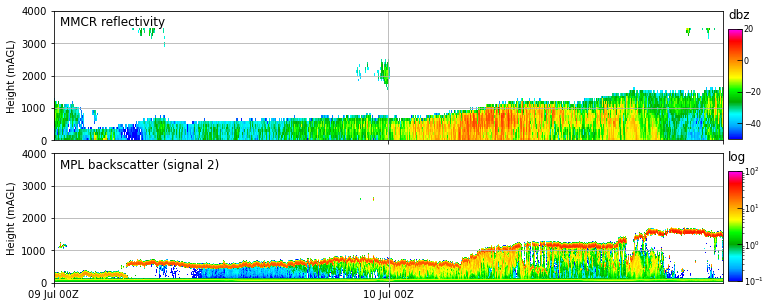

In [440]:
plot_time = time.time()

fig = plt.figure(figsize=(12,5),facecolor='white')
ax1 = fig.add_subplot(211)
#ax1.set_xlim(start_date,stop_date)
#ax1.set_xlim(mergesonde_t.index[0],mergesonde_t.index[-1])
rf = ax1.pcolormesh(mmcr.time.values,mmcr.heights,np.transpose(mmcr.Reflectivity.values),cmap = 'pyart_RefDiff', vmin=-50, vmax=20) 
ax1.set_ylabel('Height (mAGL)')
ax1.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax1.xaxis.set_major_locator(md.HourLocator(interval=24))
ax1.set_ylim(0,4000)
ax1.grid('on')
ax1.set_title('MMCR reflectivity',y=1.0, pad=-15,x = 0.01, ha = 'left')
ax1.set_xticklabels([])
cax = inset_axes(ax1, width="2%", height="85%", loc='lower left',
                   bbox_to_anchor=(1.0,-0.025,1,1), bbox_transform=ax1.transAxes)
cbar = fig.colorbar(rf,cax=cax,orientation='vertical')
cbar.ax.tick_params(axis='y', direction='in', labelsize = 8, pad = 2, width = 0.75, length = 5)
cax.set_title('dbz', y = 1.01, x = 0.0, 
                      fontsize = 12, va = 'bottom', ha = 'left')


ax6 = fig.add_subplot(212)
#ax6.set_xlim(start_date,stop_date)
#ax6.set_xlim(mergesonde_t.index[0],mergesonde_t.index[-1])
rf = ax6.pcolormesh(mpl.time.values,mpl.height*1000,np.transpose(mpl.signal_2.values),cmap = 'pyart_RefDiff',norm=colors.LogNorm(vmin=0.1, vmax=100)) 
ax6.set_ylabel('Height (mAGL)')
ax6.xaxis.set_major_formatter(md.DateFormatter('%d %b %HZ'))
ax6.xaxis.set_major_locator(md.HourLocator(interval=24))
ax6.set_ylim(0,4000)
ax6.grid('on')
ax6.set_title('MPL backscatter (signal 2)',y=1.0, pad=-15,x = 0.01, ha = 'left')
#ax6.set_xticklabels([])
cax = inset_axes(ax6, width="2%", height="85%", loc='lower left',
                   bbox_to_anchor=(1.0,-0.025,1,1), bbox_transform=ax6.transAxes)
cbar = fig.colorbar(rf,cax=cax,orientation='vertical')
cbar.ax.tick_params(axis='y', direction='in', labelsize = 8, pad = 2, width = 0.75, length = 5)
cax.set_title('log', y = 1.01, x = 0.0, 
                      fontsize = 12, va = 'bottom', ha = 'left')

plt.subplots_adjust(hspace=0.1)   



In [441]:
plot_time = time.time()-plot_time
total_time = time.time()-start_time

print(f'data import: {data_time:.2f} seconds')
print(f'plotting: {plot_time:.2f} seconds')
print(f'total: {plot_time+data_time:.2f} seconds')

data import: 4.20 seconds
plotting: 6.43 seconds
total: 10.63 seconds


### Lidar

In [427]:
def read_lidar_data(start_date,stop_date): 
    '''
    Function to read in mpl lidar files between two dates, apply range squared correction, overlap correction and remove background and then output xarray dataset
    
    Input dates in format YYYY-MM-DD
    '''
    #start_time = time.time()
    dpath = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/ingested/'

    date_list = pd.date_range(start_date,stop_date,freq='1D')
    all_files = []

    for date in date_list:
        try:
            all_files.append(glob.glob(dpath+ 'smtmplpolX1.a1.%s*.cdf'%(dt.datetime.strftime(date,'%Y%m%d'))))
        except Exception as e:
            print(e)
            print('No file for %s'%str(date))
            continue  

    flatten = lambda l: [item for sublist in l for item in sublist]
    all_files = flatten(all_files)

    mpl_data = xr.open_mfdataset(all_files,concat_dim = 'time', combine = 'nested')
    mpl_data = mpl_data.isel(height = slice(201,len(mpl_data.height)))
    
    times = mpl_data.base_time.values + mpl_data.time_offset.values 
    mpl_data = mpl_data.assign_coords(time =times)
    
    ocorr = [0.00530759, 0.0583835, 0.110524, 0.174668, 0.246036, 0.333440, 0.421466,0.510560, 0.599191, 0.676644, 0.744512, 0.808004, 0.848976,0.890453, 0.959738, 0.975302, 1.0, 1.0]
    oht = [0.0149896, 0.164886, 0.314782, 0.464678, 0.614575, 0.764471, 0.914367,1.06426, 1.21416, 1.36406, 1.51395, 1.66385, 1.81374, 1.96364,2.11354, 2.26343, 2.5, 20]
    #olap = interpol(ocorr, oht, ht)
    from scipy import interpolate
    interpfunc = interpolate.interp1d(oht,ocorr,kind='linear')
    olap = interpfunc(mpl_data.height.values)

    bk1 = np.max(mpl_data.backscatter_1.values[:,750:])
    bk2 = np.max(mpl_data.backscatter_2.values[:,750:])

    sig1 = mpl_data.backscatter_1.where(mpl_data.backscatter_1>0.6) 
    sig2 = mpl_data.backscatter_2.where(mpl_data.backscatter_2>0.6)

    sig1 = (sig1 - bk1)*mpl_data.height.values*mpl_data.height.values
    sig2 = (sig2 - bk2)*mpl_data.height.values*mpl_data.height.values

    sig1 = sig1 / olap
    sig2 = sig2 / olap

    d = sig1 / (sig1 + sig2)

    mpl_data = mpl_data.assign(signal_1=(['time','height'],sig1.values))
    mpl_data = mpl_data.assign(signal_2=(['time','height'],sig2.values))
    mpl_data = mpl_data.assign(depol_ratio=(['time','height'],d.values))
    
    #print("--- %s seconds ---" % (time.time() - start_time))
    
    return mpl_data

def read_radar_data(start_date,stop_date,mode_idx, mask_sn): 
    '''
    Function to read processed radar files between two dates, select data from one mode and output one xarray dataset
    
    Input: 
     - dates: in format YYYY-MM-DD
     - mask_sn: boolean, True masks data where signal to noise ratio <-14
    '''
    #start_time = time.time()
    dpath = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mmcr/processed/'
    
    all_files = []
    date_list = pd.date_range(start_date,stop_date,freq='1D')

    for date in date_list:
        all_files.append(glob.glob(dpath+ 'smtmmcrmomX1.b1.%s*.cdf'%dt.datetime.strftime(date,format='%Y%m%d')))

    flatten = lambda l: [item for sublist in l for item in sublist]
    all_files = flatten(all_files)
    all_files.sort()

    # get heights to add back later (necessary due to problem with xarray trying to input netcdf with a variable and dimension called 'heights')
    mmcr_heights = netCDF4.Dataset(all_files[0],'r')
    height_vals = mmcr_heights.variables['heights'][:]

    mmcr_data = xr.open_mfdataset(all_files,concat_dim = 'time', combine = 'nested',drop_variables='heights')
    
    #reassign height values 
    mmcr_data = mmcr_data.assign(height_vals=(['mode','heights'],height_vals))
    
    # select data from chosen mode
    mmcr_data = mmcr_data.sel(mode = mode_idx)
    mmcr_data = mmcr_data.where(mmcr_data.ModeNum==3., drop = True)
    
    mmcr_data = mmcr_data.assign_coords(time =mmcr_data.time_offset)
    mmcr_data = mmcr_data.assign_coords(heights =mmcr_data.height_vals[:,0].values)
    
    if mask_sn:
        mmcr_data = mmcr_data.where(mmcr_data.SignalToNoiseRatio>-14)
        
    #print("--- %s seconds ---" % (time.time() - start_time))
    return mmcr_data

<xarray.DataArray 'time_offset' (time: 26823, heights: 40)>
array([['2019-07-09T00:00:05.561000000', '2019-07-09T00:00:05.561000000',
        '2019-07-09T00:00:05.561000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2019-07-09T00:00:11.436000000', '2019-07-09T00:00:11.436000000',
        '2019-07-09T00:00:11.436000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2019-07-09T00:00:18.436000000', '2019-07-09T00:00:18.436000000',
        '2019-07-09T00:00:18.436000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['2019-07-10T23:59:45.092000000', '2019-07-10T23:59:45.092000000',
        '2019-07-10T23:59:45.092000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2019-07-10T23:59:52.108000000', '2019-07-10T23:59:52.108000000',
        '2019-07-10T23:59:52.108000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2019-07-10T23:59:57.983000000', '2019-07-10T23:59:57.983000000',
        '2019-07-10T23:59:57.983000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-07-09T00:00:05.561000 ... 2019-07-10T...
  * heights  (heights) float32 31.97 119.4 206.8 ... 3.354e+03 3.441e+03
Attributes:
    long_name:  Time offset from base_time